In [70]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost as cb
import shap
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer

from utils import *

# Predicting next purchase day

Knowing what a customer wants even before they buy a product is imperative to thrive in this digital world. It gets more customer-centric, with organizations wanting to know every bit about the customer, predict everything around the customer and take suitable action to create a swell in the number of loyal customers.

And there is customer behavior data that offers nuggets of customer wisdom. As part of this ‘predicting everything around the customer’ exercise, there is also a growing need to predict customer next day purchase, with the behavioral data rising in relevance to know when customers would buy next.

One of the key aspects in predicting customer’s next day purchase would be the behavioral data. Many data wrangling and feature engineering techniques are applied to bring out the most from data towards predicting the customer’s next purchase day. Some of the most common features leveraged in predicting the next purchase day would be the RFM metrics.

*Source:* [Saksoft](https://www.saksoft.com/blog/predicting-customer-next-purchase-day/)

Just like before, we'll be using the datasets from Group 1 as the basis for our visualizations and analyses. Visualizations for the other groups can be seen in the Streamlit app.

Lez go.

In [71]:
# Group 1:
# items1 = pd.read_csv('data/Created in part 01/group1_items.csv', index_col='Invoice', parse_dates=['InvoiceDate'])
invoices = (
    pd.read_csv('../data/Created in part 01/group1_invoices.csv', index_col='Invoice', parse_dates=['InvoiceDate'])
    .pipe(adjust_time_window)
    .pipe(normalize_invoicedate)
    .pipe(clean_customer_id)
)   # importing our dataset of invoices and using all that preprocessing from part 02

In [72]:
invoices.rename({'Customer ID': 'CustomerID'}, axis=1, inplace=True)

___
- # Labels

Labels, basically, are what we are trying to predict, in this case, the number of days between the last purchase before a cutoff date and the next purchase after this date.

In other words, labels are the **y** in regression problems.

We'll be using the first 8 months of data to analyze customer behavior and then use the other 3 months of data to check if our predictions are correct.

That's respectively `invoices_jan_aug` and `invoices_sep_nov`.

In [73]:
invoices_jan_aug = invoices.query("InvoiceDate < '2010-08-01'")   # used to "train"
invoices_sep_nov = invoices.query("InvoiceDate >= '2010-08-01'")   # used to "test"

Let's start off by getting the last known purchase from the 8-month df, for every customer, and then the first purchase on the other 3-month span.

In [74]:
last_purchase = invoices_jan_aug.groupby('CustomerID')['InvoiceDate'].max().rename('LastPurchase')
first_purchase = invoices_sep_nov.groupby('CustomerID')['InvoiceDate'].min().rename('FirstPurchase')

Now let's create a df of unique CustomerID's and populate it with relevant info, starting by merging the previously created Series into this new df.

"Why is `invoices_jan_aug` being used instead of `invoices`?", you may ask. Well, some customers made their first purchase between the 3-month span we are using to test our model, i.e., they don't have any data available and can't have their next purchase predicted. Using `invoices_jan_aug` captures only customers who made at least one purchase between Jan and Aug.

In [75]:
customers = pd.DataFrame({'CustomerID': invoices_jan_aug['CustomerID'].unique()})

# Merges. How='left' asserts that `customers` only has customers already in `customers`
customers = customers.merge(last_purchase, how='left', left_on='CustomerID', right_on='CustomerID')
customers = customers.merge(first_purchase, how='left', left_on='CustomerID', right_on='CustomerID')

And now the day difference between the last purchase and the next one (the one to be predicted).

In [76]:
customers['NextDayPurchase'] = (customers['FirstPurchase'] - customers['LastPurchase']).dt.days

customers.head()   # just checking how our df is looking so far

,CustomerID,LastPurchase,FirstPurchase,NextDayPurchase
0,14739,2010-07-28,2010-08-20,23.0
1,14370,2010-06-05,2010-08-08,64.0
2,12810,2010-06-23,NaT,NaN
3,16684,2010-07-06,2010-08-19,44.0
4,14047,2010-07-19,2010-08-17,29.0


____
- # Features

Our model needs features, right? Let's go get those **X**'s for our prediction problem.

Our feature candidates are:
- Days between the last 3 purchases;
- Standard deviation and mean of the difference of days between purchases;
- RFM data (check the notebook from part 03).

Right. So first we need a new df for the next steps. To get the difference in days of the last 3 purchases, we must first remove same-day purchases.

In [77]:
last_3_purchases = (
    invoices_jan_aug
    [['CustomerID','InvoiceDate']]
    .sort_values(['CustomerID', 'InvoiceDate'])
    .drop_duplicates()   # removes duplicated rows, i.e., same-day purchases from a single customer
)

Things get tricky here! 

To get the difference between the last three purchases, we need to push forward the date of the purchase by 1, 2 and 3 periods, and then subtract the dates from the original index order. Confusing, right? Let's go step by step, checking how that would look for one of our customers.

We *randomly* select you, customer whose ID is `12431`!

Let's see how their data looks inside our almighty df:

In [78]:
last_3_purchases.query("`CustomerID` == '12431'")

,CustomerID,InvoiceDate
Invoice,,
536389,12431,2010-01-12
494511,12431,2010-01-15
521203,12431,2010-02-09
500008,12431,2010-04-03
509212,12431,2010-05-21
509572,12431,2010-05-24
514810,12431,2010-06-07
513310,12431,2010-06-23
516307,12431,2010-07-19


In [79]:
# And then some math...
last_3_purchases['InvoiceDate-1'] = last_3_purchases.groupby('CustomerID')['InvoiceDate'].shift(1)
last_3_purchases['InvoiceDate-2'] = last_3_purchases.groupby('CustomerID')['InvoiceDate'].shift(2)
last_3_purchases['InvoiceDate-3'] = last_3_purchases.groupby('CustomerID')['InvoiceDate'].shift(3)

Let's check how customer `12431` is doing.

In [80]:
# The dates were pushed forward by 1, 2, 3 and then aligned
last_3_purchases.query("`CustomerID` == '12431'")

,CustomerID,InvoiceDate,InvoiceDate-1,InvoiceDate-2,InvoiceDate-3
Invoice,,,,,
536389,12431,2010-01-12,NaT,NaT,NaT
494511,12431,2010-01-15,2010-01-12,NaT,NaT
521203,12431,2010-02-09,2010-01-15,2010-01-12,NaT
500008,12431,2010-04-03,2010-02-09,2010-01-15,2010-01-12
509212,12431,2010-05-21,2010-04-03,2010-02-09,2010-01-15
509572,12431,2010-05-24,2010-05-21,2010-04-03,2010-02-09
514810,12431,2010-06-07,2010-05-24,2010-05-21,2010-04-03
513310,12431,2010-06-23,2010-06-07,2010-05-24,2010-05-21
516307,12431,2010-07-19,2010-06-23,2010-06-07,2010-05-24


Good.

Now let's do the math and get the differences in days, not in timestamps.

In [81]:
last_3_purchases['DayDiff1'] = (last_3_purchases['InvoiceDate'] - last_3_purchases['InvoiceDate-1']).dt.days
last_3_purchases['DayDiff2'] = (last_3_purchases['InvoiceDate'] - last_3_purchases['InvoiceDate-2']).dt.days
last_3_purchases['DayDiff3'] = (last_3_purchases['InvoiceDate'] - last_3_purchases['InvoiceDate-3']).dt.days

Step up, `12431`!

In [82]:
# The last 3 columns have the difference in days between the actual invoice and the previous 3
last_3_purchases.query("`CustomerID` == '12431'")

,CustomerID,InvoiceDate,InvoiceDate-1,InvoiceDate-2,InvoiceDate-3,DayDiff1,DayDiff2,DayDiff3
Invoice,,,,,,,,
536389,12431,2010-01-12,NaT,NaT,NaT,NaN,NaN,NaN
494511,12431,2010-01-15,2010-01-12,NaT,NaT,3.0,NaN,NaN
521203,12431,2010-02-09,2010-01-15,2010-01-12,NaT,25.0,28.0,NaN
500008,12431,2010-04-03,2010-02-09,2010-01-15,2010-01-12,53.0,78.0,81.0
509212,12431,2010-05-21,2010-04-03,2010-02-09,2010-01-15,48.0,101.0,126.0
509572,12431,2010-05-24,2010-05-21,2010-04-03,2010-02-09,3.0,51.0,104.0
514810,12431,2010-06-07,2010-05-24,2010-05-21,2010-04-03,14.0,17.0,65.0
513310,12431,2010-06-23,2010-06-07,2010-05-24,2010-05-21,16.0,30.0,33.0
516307,12431,2010-07-19,2010-06-23,2010-06-07,2010-05-24,26.0,42.0,56.0


I hope that made sense...

Now we need the mean and the standard deviation of the difference between purchases.

In [83]:
mean_and_std_df = last_3_purchases.groupby('CustomerID', as_index=False).agg(
   DayDiffmean = pd.NamedAgg('DayDiff1', 'mean'),
   DayDiffstd = pd.NamedAgg('DayDiff1', 'std') 
)

Some customers only had 1 or 2 purchases, hence so many `NaN`'s. When predicting stuff, the more data you have for training, the better. Predict next purchase day of a customer who only had 1 or 2 purchases is kind of dumb.

We should focus on *frequent* customers, i.e., customers with ***at least*** 4 purchases. For customers with more than 4 purchases, we are gonna only select data from the last 4 purchases.

`pandas`-ly speaking, this means:

In [84]:
last_3_purchases = (
    last_3_purchases
    .dropna()   # if a row has a NaN, it means that row does not have all data from the last 4 purchases
    .drop_duplicates(subset=['CustomerID'],keep='last')   # ok, this customer has at least 4 purchases, but we only want the last 4
)

And finally, our RFM data from part 03!

In [85]:
# This function generates a df with RFM from any df of invoices. Check `utils.py` for more info.
rfm_df = preprocessing_part_03(invoices.rename({'CustomerID': 'Customer ID'}, axis=1))

Before merging everything into our `customers` df, let's clean up all unneeded columns from each df to be merged (and from `customers` itself).

In [86]:
customers = customers[['CustomerID', 'NextDayPurchase']]
last_3_purchases = last_3_purchases[['CustomerID', 'DayDiff1','DayDiff2','DayDiff3']]
mean_and_std_df = mean_and_std_df[['CustomerID', 'DayDiffmean','DayDiffstd']]
rfm_df = rfm_df[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'MonetaryCluster', 'Score', 'Segment']]

In [87]:
customers = customers.merge(last_3_purchases, on='CustomerID')
customers = customers.merge(mean_and_std_df, on='CustomerID')
customers = customers.merge(rfm_df, on='CustomerID')

customers   # let's see how it looks

,CustomerID,NextDayPurchase,DayDiff1,DayDiff2,DayDiff3,DayDiffmean,DayDiffstd,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,Score,Segment
0,14739,23.0,12.0,16.0,62.0,20.700000,14.353087,30,4,16,1,439.72,1,6,Mid
1,16684,44.0,6.0,71.0,76.0,30.833333,25.717050,5,4,24,2,1158.64,1,7,Mid
2,14047,29.0,67.0,69.0,99.0,33.000000,21.166010,105,2,10,1,522.52,1,4,Mid
3,12540,76.0,34.0,62.0,66.0,23.571429,28.242150,4,4,14,1,718.20,1,6,Mid
4,17969,42.0,21.0,22.0,42.0,18.545455,10.043542,86,3,13,1,614.84,1,5,Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,16059,113.0,15.0,17.0,30.0,13.800000,7.259477,13,4,7,1,654.22,1,6,Mid
653,14745,NaN,49.0,51.0,62.0,15.750000,22.618208,127,2,6,1,106.12,0,3,Low
654,13324,39.0,15.0,17.0,46.0,15.333333,13.503086,77,3,8,1,191.41,0,4,Mid
655,14626,53.0,16.0,19.0,55.0,18.333333,16.623277,65,3,6,1,249.31,0,4,Mid


___
- # Class definition

Now we need to define the classes that will be assigned to our labels (reminder: `NextPurchaseDay` column). Here they are:
- Class 2: customers that will purchase in the next 0 - 20 days;
- Class 1: customers that will purchase in the next 21 - 49 days;
- Class 0: customers that will purchase in more than 50 days.

Before assigning labels, we must check if there are no `NaN`'s in the `NextDayPurchase` column. 

In [88]:
customers.NextDayPurchase.isna().sum()

58

Why is that so? 

Well, some customers might had 4 purchases in those first 8 months, but they didn't come back in the other 3 months. Bummer, I know.

In other words, their next day of purchase is over 3 months (90+ days). Or maybe never. Either way, they belong to class 0, so let's just fill those `NaN`'s with a high numeric value.

In [89]:
customers = customers.fillna(90)

customers['Labels'] = 2
customers.loc[customers['NextDayPurchase'] > 20, 'Labels'] = 1
customers.loc[customers['NextDayPurchase'] > 50, 'Labels'] = 0

How balanced are these classes?

In [90]:
customers.Labels.value_counts()

0    345
1    196
2    116
Name: Labels, dtype: int64

...and in %...

In [91]:
customers.Labels.value_counts(normalize=True)

0    0.525114
1    0.298326
2    0.176560
Name: Labels, dtype: float64

___
- # ...and now a few words ~~from our sponsors~~

ML is not all about running a bunch of models, picking the one with best accuracy or R² and then running a grid search on it.

It goes beyond that.

Sometimes a simple model will fit your needs, and that's ok to do it like I mentioned before. Other times, a thorough evaluation is imperative, or loss/damage can be caused. [Leonard A. Smith](https://twitter.com/lynyrdsmyth) once said: "all models are wrong, but some are dangerous".

The approach herein described is neither shallow nor deep, and it only serves as educational purposes.

___
- # Feature selection

"Wait, I though that's what we were doing in the last steps..."

Well, yeah... ***Sort of***.

We chose those features and now we could go on and train our model. However, do these features have predictive power over our labels? Are all of them *really* relevant?



In [208]:
###
# Draft (from this line on)
###

In [93]:
X = customers.drop(['NextDayPurchase', 'Segment', 'Score'], axis=1).set_index('CustomerID', drop=True).astype({'RecencyCluster': 'category', 'FrequencyCluster': 'category', 'MonetaryCluster': 'category'})
y = X.pop('Labels').astype('category')

In [94]:
cat_features = ['RecencyCluster', 'FrequencyCluster', 'MonetaryCluster']
num_features = ['DayDiff1', 'DayDiff2', 'DayDiff3', 'DayDiffmean', 'DayDiffstd', 'Recency', 'Frequency', 'Monetary']

In [95]:
random_state = 13

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

In [96]:
scaler1 = RobustScaler()
scaler2 = MinMaxScaler()
ct1 = make_column_transformer((scaler1, num_features), remainder='passthrough')
ct2 = make_column_transformer((scaler2, num_features), remainder='passthrough')

In [97]:
cv = StratifiedKFold(10, shuffle=True, random_state=random_state)

models_list = [
    ('RF', RandomForestClassifier(random_state=random_state)),
    ('LR', LogisticRegression(max_iter=2000, random_state=random_state)),
    ('AB', AdaBoostClassifier(random_state=random_state))
]

In [98]:
rfcev_results1 = {}
rfcev_results2 = {}
for name, model in models_list:
    rfecv = RFECV(model, scoring='balanced_accuracy', cv=cv)
    pipe1 = make_pipeline(ct1, rfecv)
    pipe1.fit(X_train, y_train)
    rfcev_results1[name] = {
        'balanced_accuracy': balanced_accuracy_score(y_test, pipe1.predict(X_test)),
        'ranking': pipe1.named_steps.rfecv.ranking_,
        'support': pipe1.named_steps.rfecv.support_,
        'mask': pipe1.named_steps.rfecv.get_feature_names_out(),
        'predict_proba': pipe1.predict_proba(X_test)
    }
    pipe2 = make_pipeline(ct2, rfecv)
    pipe2.fit(X_train, y_train)
    rfcev_results2[name] = {
        'balanced_accuracy': balanced_accuracy_score(y_test, pipe2.predict(X_test)),
        'ranking': pipe2.named_steps.rfecv.ranking_,
        'support': pipe2.named_steps.rfecv.support_,
        'mask': pipe2.named_steps.rfecv.get_feature_names_out(),
        'predict_proba': pipe2.predict_proba(X_test)
    }

In [99]:
rfcev_df = pd.DataFrame()
for name, model in models_list:
    rfcev_df = rfcev_df.join(pd.DataFrame(rfcev_results1[name]['support'], columns=[name]), how='right', lsuffix='_1', rsuffix='_2')
    rfcev_df = rfcev_df.join(pd.DataFrame(rfcev_results2[name]['support'], columns=[name]), how='right', lsuffix='_1', rsuffix='_2')
rfcev_df.index = X_train.columns
rfcev_df = rfcev_df.T
rfcev_df

,DayDiff1,DayDiff2,DayDiff3,DayDiffmean,DayDiffstd,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster
RF_1,False,False,False,True,True,True,True,True,False,False,False
RF_2,False,False,False,True,True,True,True,True,False,False,False
LR_1,True,True,True,True,True,True,True,True,True,True,True
LR_2,False,True,False,True,False,False,True,False,False,True,False
AB_1,True,False,True,True,False,True,True,False,False,False,False
AB_2,True,False,True,True,False,True,True,False,False,False,False


In [100]:
pd.DataFrame(rfcev_results1).loc['balanced_accuracy']

RF    0.576436
LR    0.474924
AB    0.539658
Name: balanced_accuracy, dtype: object

In [101]:
rfcev_df.sum()

DayDiff1            3
DayDiff2            2
DayDiff3            3
DayDiffmean         6
DayDiffstd          3
Recency             5
RecencyCluster      6
Frequency           3
FrequencyCluster    1
Monetary            2
MonetaryCluster     1
dtype: int64

In [102]:
score_funcs = [
    ('CHI', chi2),
    ('ANOVA', f_classif),
    ('MI', mutual_info_classif)
    ]
kbest_results = {}
for name, score in score_funcs:
    kbest_results[name] = {}
    for i in np.arange(3,11):
        kbest = SelectKBest(k=i, score_func=score)
        pipe2 = make_pipeline(ct2, kbest)
        pipe2.fit(X_train, y_train)
        kbest_results[name][i] = pipe2.named_steps.selectkbest.get_support()

In [103]:
kbest_df = pd.DataFrame()
for name, score in score_funcs:
    for i in np.arange(3,11):
        kbest_df = kbest_df.join(pd.DataFrame(kbest_results[name][i], columns=[str(name) + '_' + str(i)]), how='right', rsuffix='_2')

kbest_df.index = X_train.columns
kbest_df = kbest_df.T
kbest_df

,DayDiff1,DayDiff2,DayDiff3,DayDiffmean,DayDiffstd,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster
CHI_3,False,False,False,False,False,False,True,False,False,True,True
CHI_4,False,False,False,False,False,True,True,False,False,True,True
CHI_5,False,False,False,False,False,True,True,False,True,True,True
CHI_6,False,False,False,False,False,True,True,True,True,True,True
CHI_7,False,False,True,False,False,True,True,True,True,True,True
CHI_8,False,False,True,True,False,True,True,True,True,True,True
CHI_9,False,True,True,True,False,True,True,True,True,True,True
CHI_10,True,True,True,True,False,True,True,True,True,True,True
ANOVA_3,False,False,False,False,False,False,True,True,False,True,False
ANOVA_4,False,False,False,False,False,True,True,True,False,True,False


In [104]:
cb_train1 = ct1.fit_transform(X_train)
cb_train1 = pd.DataFrame(cb_train1).astype({8: 'int', 9: 'int', 10: 'int'})
cb_train1.columns = ct1.get_feature_names_out()
cb_train1

,robustscaler__DayDiff1,robustscaler__DayDiff2,robustscaler__DayDiff3,robustscaler__DayDiffmean,robustscaler__DayDiffstd,robustscaler__Recency,robustscaler__Frequency,robustscaler__Monetary,remainder__RecencyCluster,remainder__FrequencyCluster,remainder__MonetaryCluster
0,1.2,1.509091,0.690141,0.229945,0.564992,-0.133333,-0.166667,1.665002,4,1,2
1,0.314286,-0.018182,-0.112676,0.407967,0.226593,0.333333,0.0,0.569312,4,1,1
2,-0.542857,-0.363636,-0.746479,-0.85112,-0.502477,-0.333333,2.833333,1.756987,4,2,2
3,1.6,0.745455,0.253521,-0.407967,0.165077,-0.155556,0.5,-0.287786,4,1,1
4,1.028571,0.763636,0.295775,0.951923,0.639313,1.177778,0.0,-0.753424,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
454,-0.6,-0.818182,-1.112676,-0.519231,0.221764,-0.133333,0.666667,0.616754,4,1,1
455,0.742857,0.909091,0.647887,0.321429,-0.126794,-0.266667,-0.5,-0.362601,4,1,0
456,1.4,0.890909,0.408451,0.123626,0.358319,0.4,0.166667,-0.72591,3,1,0
457,-0.2,0.090909,0.422535,0.180495,-0.142477,0.244444,-0.166667,-0.278007,4,1,1


In [105]:
cb_clf1 = cb.CatBoostClassifier(random_state=random_state, verbose=0, cat_features=cb_train1.columns[-3:].tolist())
cb_clf1.fit(cb_train1, y_train)

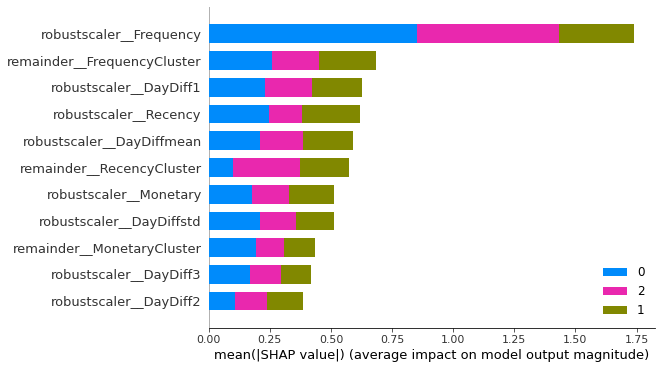

In [106]:
# create a Pool object to store data, as it is mandatory in .get_feature_importance()
pool1 = cb.Pool(data=cb_train1, label=y_train, cat_features=cb_train1.columns[-3:].tolist())
# get shap values
shap_values1 = cb_clf1.get_feature_importance(data=pool1, type='ShapValues')

shap_values_transposed1 = shap_values1.transpose(1, 0, 2)

# Then we convert the transposed shap values into a list, where each element will be a 2D numpy matrix of shape [#samples, #features] as expected by the shap package
shap.summary_plot(list(shap_values_transposed1[:,:,:-1]), features=cb_clf1.feature_names_, class_names=y_train.unique())

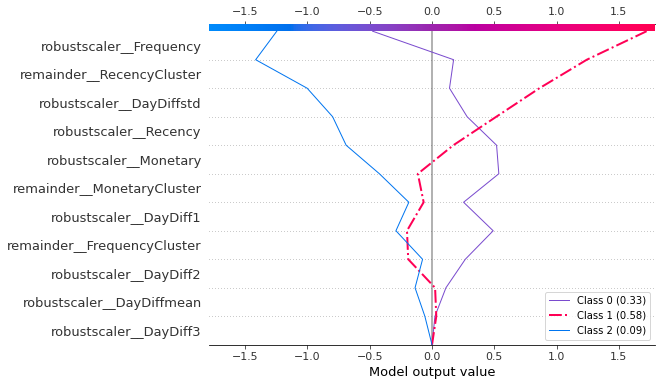

In [107]:
heart_base_values = list(shap_values_transposed1[:,:,-1])
heart_base_values[0] = heart_base_values[0].reshape(-1, 1)
heart_base_values[1] = heart_base_values[1].reshape(-1, 1)
heart_base_values[2] = heart_base_values[2].reshape(-1, 1)
heart_shap_values = list(shap_values_transposed1[:,:,:-1])
cb_test1 = ct1.transform(X_test)
cb_test1 = pd.DataFrame(cb_test1).astype({8: 'int', 9: 'int', 10: 'int'})
cb_test1.columns = ct1.get_feature_names_out()
heart_predictions = cb_clf1.predict_proba(cb_test1)
class_count = len(heart_base_values)

def class_labels(row_index):
    return [f'Class {i} ({heart_predictions[row_index, i].round(2)})' for i in range(class_count)]

row_index = -5
shap.multioutput_decision_plot(heart_base_values, heart_shap_values,
                               row_index=row_index,
                               feature_names=ct1.get_feature_names_out().tolist(),
                               highlight=[np.argmax(heart_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right'
                               )

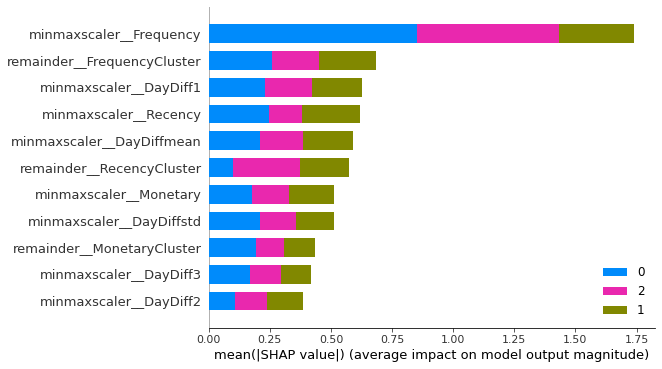

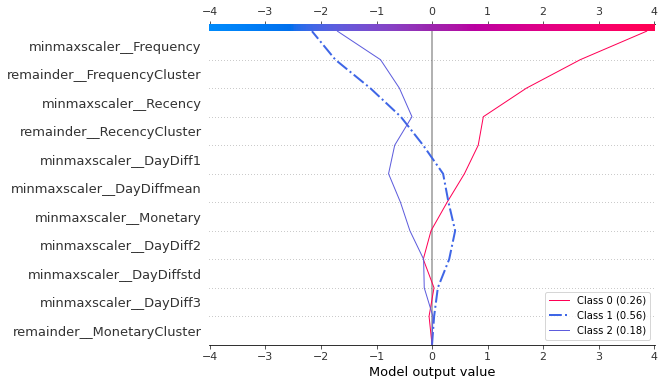

In [108]:
cb_train2 = ct2.fit_transform(X_train)
cb_train2 = pd.DataFrame(cb_train2).astype({8: 'int', 9: 'int', 10: 'int'})
cb_train2.columns = ct2.get_feature_names_out()

cb_clf2 = cb.CatBoostClassifier(random_state=random_state, verbose=0, cat_features=cb_train2.columns[-3:].tolist())
cb_clf2.fit(cb_train2, y_train)
# create a Pool object to store data, as it is mandatory in .get_feature_importance()
pool2 = cb.Pool(data=cb_train2, label=y_train, cat_features=cb_train2.columns[-3:].tolist())
# get shap values
shap_values2 = cb_clf2.get_feature_importance(data=pool2, type='ShapValues')

shap_values_transposed2 = shap_values2.transpose(1, 0, 2)

# Then we convert the transposed shap values into a list, where each element will be a 2D numpy matrix of shape [#samples, #features] as expected by the shap package
shap.summary_plot(list(shap_values_transposed2[:,:,:-1]), features=cb_clf2.feature_names_, class_names=y_train.unique())

heart_base_values = list(shap_values_transposed2[:,:,-1])
heart_base_values[0] = heart_base_values[0].reshape(-1, 1)
heart_base_values[1] = heart_base_values[1].reshape(-1, 1)
heart_base_values[2] = heart_base_values[2].reshape(-1, 1)
heart_shap_values = list(shap_values_transposed2[:,:,:-1])
cb_test2 = ct2.transform(X_test)
cb_test2 = pd.DataFrame(cb_test2).astype({8: 'int', 9: 'int', 10: 'int'})
cb_test2.columns = ct2.get_feature_names_out()
heart_predictions = cb_clf2.predict_proba(cb_test2)
class_count = len(heart_base_values)

def class_labels(row_index):
    return [f'Class {i} ({heart_predictions[row_index, i].round(2)})' for i in range(class_count)]

row_index = 11
shap.multioutput_decision_plot(heart_base_values, heart_shap_values,
                               row_index=row_index,
                               feature_names=ct2.get_feature_names_out().tolist(),
                               highlight=[np.argmax(heart_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right'
                               )

In [109]:
cb_clf2.predict_proba(cb_test2)

array([[1.34210375e-01, 8.39706562e-01, 2.60830631e-02],
       [9.63387483e-01, 3.38785985e-02, 2.73391818e-03],
       [8.42169517e-01, 1.50737782e-01, 7.09270100e-03],
       [9.95272868e-01, 3.03056380e-03, 1.69656857e-03],
       [3.89425299e-01, 5.69277456e-01, 4.12972453e-02],
       [3.01498007e-01, 6.69022803e-01, 2.94791897e-02],
       [6.96880753e-01, 2.97166522e-01, 5.95272511e-03],
       [3.44075901e-01, 6.15941751e-01, 3.99823484e-02],
       [2.68981335e-01, 7.02850669e-01, 2.81679962e-02],
       [9.62403747e-01, 2.47869236e-02, 1.28093295e-02],
       [2.24904588e-01, 7.70839014e-01, 4.25639795e-03],
       [2.59361243e-01, 5.57618956e-01, 1.83019801e-01],
       [1.21500911e-02, 5.61527464e-01, 4.26322445e-01],
       [8.63114678e-01, 1.22381643e-01, 1.45036790e-02],
       [7.17342125e-01, 2.40480279e-01, 4.21775964e-02],
       [2.72281038e-02, 2.51675780e-01, 7.21096116e-01],
       [8.52327198e-01, 1.39734830e-01, 7.93797243e-03],
       [3.75580086e-01, 4.45449

In [110]:
cb_clf2.score(cb_test2, y_test)

0.6414141414141414

In [111]:
cb_clf1.score(cb_test1, y_test)

0.6414141414141414

In [112]:
cb_clfX.score(aTEST, y_test)

NameError: name 'cb_clfX' is not defined

In [ ]:
y_test

CustomerID
15785    0
17281    0
15571    0
13209    0
16655    0
        ..
14064    1
12583    1
14744    0
15719    1
13152    0
Name: Labels, Length: 198, dtype: int64

In [ ]:
cb_clf = cb.CatBoostClassifier(random_state=random_state, verbose=0, cat_features=[8])
pipe = make_pipeline(ct1, cb_clf)
pipe.fit(X_train, y_train)

CatBoostError: 'data' is numpy array of floating point numerical type, it means no categorical features, but 'cat_features' parameter specifies nonzero number of categorical features

In [ ]:
pipe.named_steps.columntransformer.get_feature_names_out()

array(['robustscaler__DayDiff1', 'robustscaler__DayDiff2',
       'robustscaler__DayDiff3', 'robustscaler__DayDiffmean',
       'robustscaler__DayDiffstd', 'robustscaler__Recency',
       'robustscaler__Frequency', 'robustscaler__Monetary',
       'remainder__RecencyCluster', 'remainder__FrequencyCluster',
       'remainder__MonetaryCluster'], dtype=object)

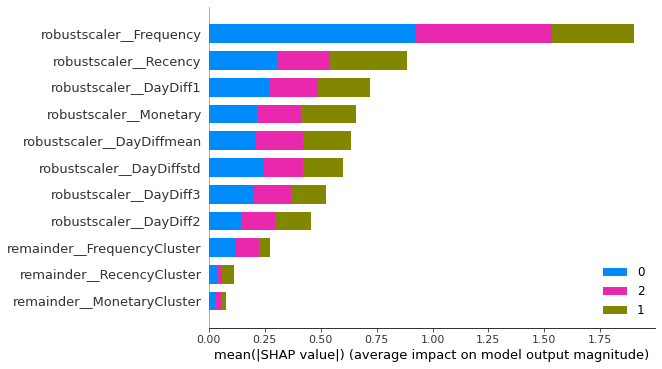

In [ ]:
# create a Pool object to store data, as it is mandatory in .get_feature_importance()
pool = cb.Pool(data=pipe.named_steps.columntransformer.transform(X_train), label=y_train)
# get shap values
shap_values = pipe.named_steps.catboostclassifier.get_feature_importance(data=pool, type='ShapValues')

shap_values_transposed = shap_values.transpose(1, 0, 2)
assert shap_values[0, 1, 2] == shap_values_transposed[1, 0, 2]  # just check we've done it right

# Then we convert the transposed shap values into a list, where each element will be a 2D numpy matrix of shape [#samples, #features] as expected by the shap package
shap.summary_plot(list(shap_values_transposed[:,:,:-1]), features=pipe.named_steps.columntransformer.get_feature_names_out(), class_names=y_train.unique())